In [106]:
import pandas as pd
import numpy as np
import copy

data_red = pd.read_csv('data/winequality-red.csv', delimiter=';')
data_white = pd.read_csv('data/winequality-white.csv', delimiter=';')
np.random.seed(42)
def create_sampled_datasets(dataset):

    dataset_sampled_10 = dataset.copy()
    dataset_sampled_20 = dataset.copy()
    dataset_sampled_30 = dataset.copy()

    sampled_datasets = [dataset_sampled_10, dataset_sampled_20, dataset_sampled_30]

    for sampled_dataset, fraction in [(dataset_sampled_10, 0.1), (dataset_sampled_20, 0.2), (dataset_sampled_30, 0.3)]:
        for col in sampled_dataset.columns:
            mask = np.random.rand(sampled_dataset.shape[0]) <= fraction
            sampled_dataset.loc[mask, col] = np.nan

        print(f"shape of dataset: {sampled_dataset.shape}")
        if sampled_dataset.isnull().sum().sum() > 0:
            print("Null values found in dataset")
        else:
            print("No null values found in dataset")

    return sampled_datasets

sampled_datasets_red = create_sampled_datasets(data_red)
sampled_datasets_white = create_sampled_datasets(data_white)

sampled_datasets = [sampled_datasets_red, sampled_datasets_white]

shape of dataset: (1599, 12)
Null values found in dataset
shape of dataset: (1599, 12)
Null values found in dataset
shape of dataset: (1599, 12)
Null values found in dataset
shape of dataset: (4898, 12)
Null values found in dataset
shape of dataset: (4898, 12)
Null values found in dataset
shape of dataset: (4898, 12)
Null values found in dataset


For easier operations on datasets, they were converted to pandas dataframes. Then all of them were saved to a list called `datasets`. The first elements of the list are red samples, and the rest are the datasets are white samples. It will make it easier to iterate over them. Then the code puts Null values to random places to make it a missing value. Now we can try different methods to handle missing values.

# Handling Missing Values

There are many ways to handle missing values in a dataset. In this notebook, I will use the simplest one: removing the rows with missing values. I will use the `dropna()` method of pandas dataframes to remove the rows with missing values. I will use the `inplace=True` parameter to make the changes permanent.

In [107]:
sampled_datasets_removal = copy.deepcopy(sampled_datasets)
for datasets in sampled_datasets_removal:
    for dataset in datasets:
        print(f"Null values in dataset before removal: {dataset.isnull().sum().sum()}")
        print(f"shape of dataset: {dataset.shape}")
        dataset.dropna(inplace=True)
        print(f"Null values in dataset after removal: {dataset.isnull().sum().sum()}")
        print(f"reduced shape of dataset: {dataset.shape} \n")

Null values in dataset before removal: 1947
shape of dataset: (1599, 12)
Null values in dataset after removal: 0
reduced shape of dataset: (453, 12) 

Null values in dataset before removal: 3787
shape of dataset: (1599, 12)
Null values in dataset after removal: 0
reduced shape of dataset: (136, 12) 

Null values in dataset before removal: 5787
shape of dataset: (1599, 12)
Null values in dataset after removal: 0
reduced shape of dataset: (19, 12) 

Null values in dataset before removal: 5900
shape of dataset: (4898, 12)
Null values in dataset after removal: 0
reduced shape of dataset: (1410, 12) 

Null values in dataset before removal: 11737
shape of dataset: (4898, 12)
Null values in dataset after removal: 0
reduced shape of dataset: (359, 12) 

Null values in dataset before removal: 17603
shape of dataset: (4898, 12)
Null values in dataset after removal: 0
reduced shape of dataset: (66, 12) 



We can see that the code removed all null values from the dataset. We lost a lot of rows, that could potentially be restored. Now one of the sets has only 19 rows of data which is so small, that it is almost impossible to train a model on it. Let's try to restore the missing values. 

# Restoring Missing Values

There are many ways to restore missing values. In this notebook, I will use the simplest one: replacing the missing values with the mean of the column. I will use the `fillna()` method of pandas dataframes to replace the missing values with the mean of the column. I will use the `inplace=True` parameter to make the changes permanent.

In [108]:
sampled_datasets_restored = copy.deepcopy(sampled_datasets)
for datasets in sampled_datasets_restored:
    for dataset in datasets:
        print(f"Null values in dataset before restore: {dataset.isnull().sum().sum()}")
        print(f"shape of dataset: {dataset.shape}")
        dataset.fillna(dataset.mean(), inplace=True)
        print(f"Null values in dataset after restore: {dataset.isnull().sum().sum()}")
        print(f"reduced shape of dataset: {dataset.shape} \n")

Null values in dataset before restore: 1947
shape of dataset: (1599, 12)
Null values in dataset after restore: 0
reduced shape of dataset: (1599, 12) 

Null values in dataset before restore: 3787
shape of dataset: (1599, 12)
Null values in dataset after restore: 0
reduced shape of dataset: (1599, 12) 

Null values in dataset before restore: 5787
shape of dataset: (1599, 12)
Null values in dataset after restore: 0
reduced shape of dataset: (1599, 12) 

Null values in dataset before restore: 5900
shape of dataset: (4898, 12)
Null values in dataset after restore: 0
reduced shape of dataset: (4898, 12) 

Null values in dataset before restore: 11737
shape of dataset: (4898, 12)
Null values in dataset after restore: 0
reduced shape of dataset: (4898, 12) 

Null values in dataset before restore: 17603
shape of dataset: (4898, 12)
Null values in dataset after restore: 0
reduced shape of dataset: (4898, 12) 



We did not loose any data. The gaps are filled with the mean of the column. Now we can try to train a model on the data. This method is not the best one, but it is the simplest one. If there are not many missing values or the values do not differ very much from each other, this method is a good choice. If the values differ a lot, this method will not work well. 

Now we can test both datasets and see which one is better. We will use the `train_test_split` method of scikit-learn to split the dataset into training and testing sets. Then we will train a model on the training set and test it on the testing set. We will use the `DecisionTreeClassifier` class of scikit-learn to train a decision tree model. We will use the `accuracy_score` method of scikit-learn to measure the accuracy of the model. We will use the `mean_squared_error` method of scikit-learn to measure the mean squared error of the model.

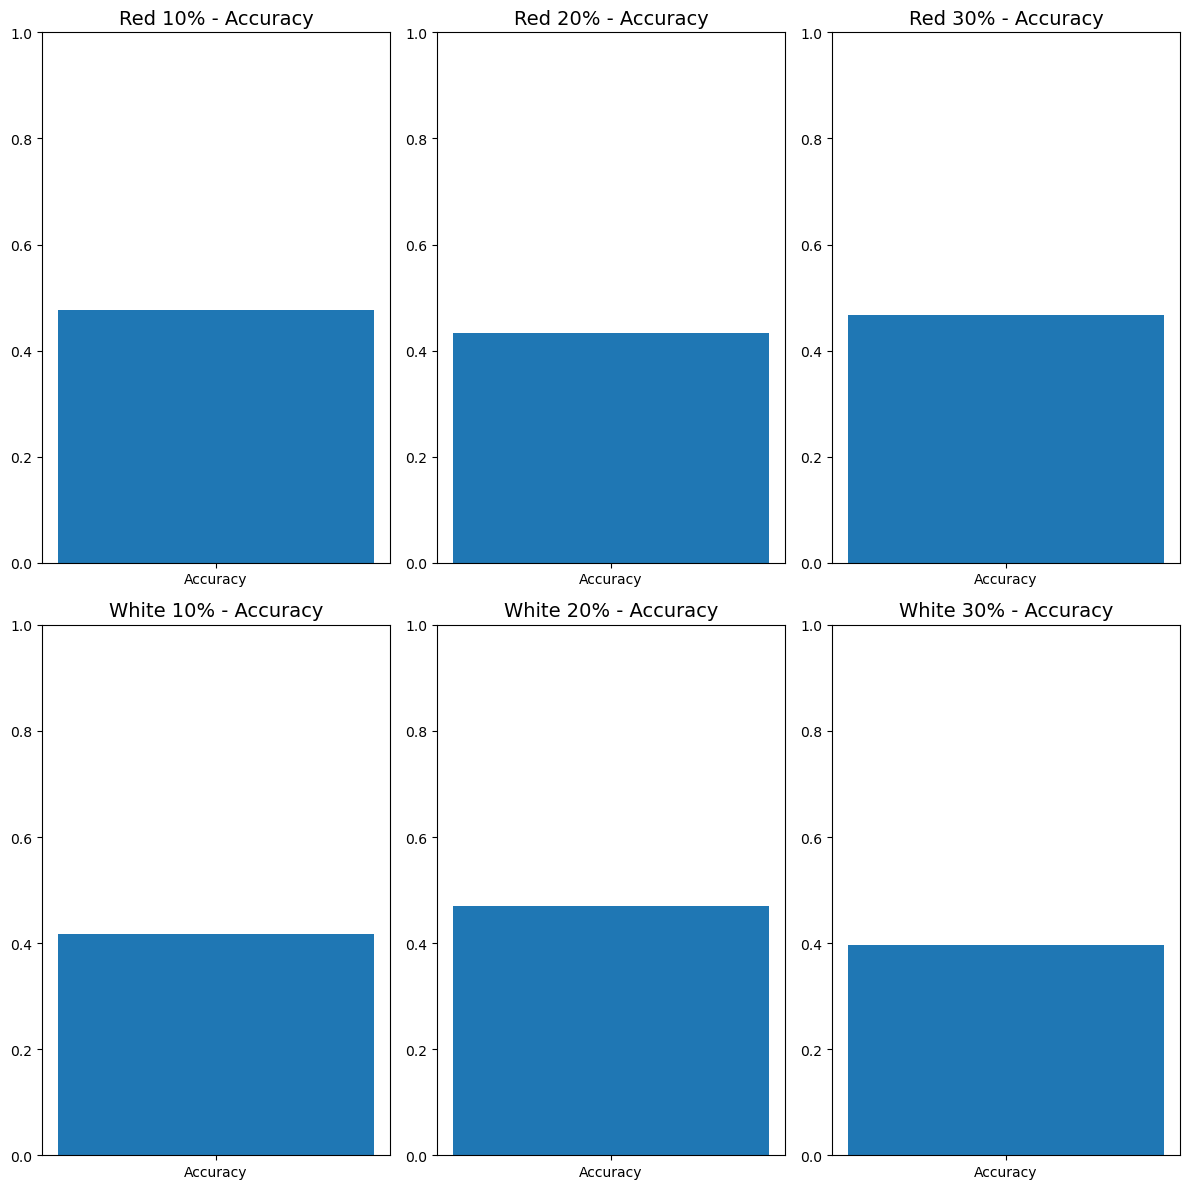

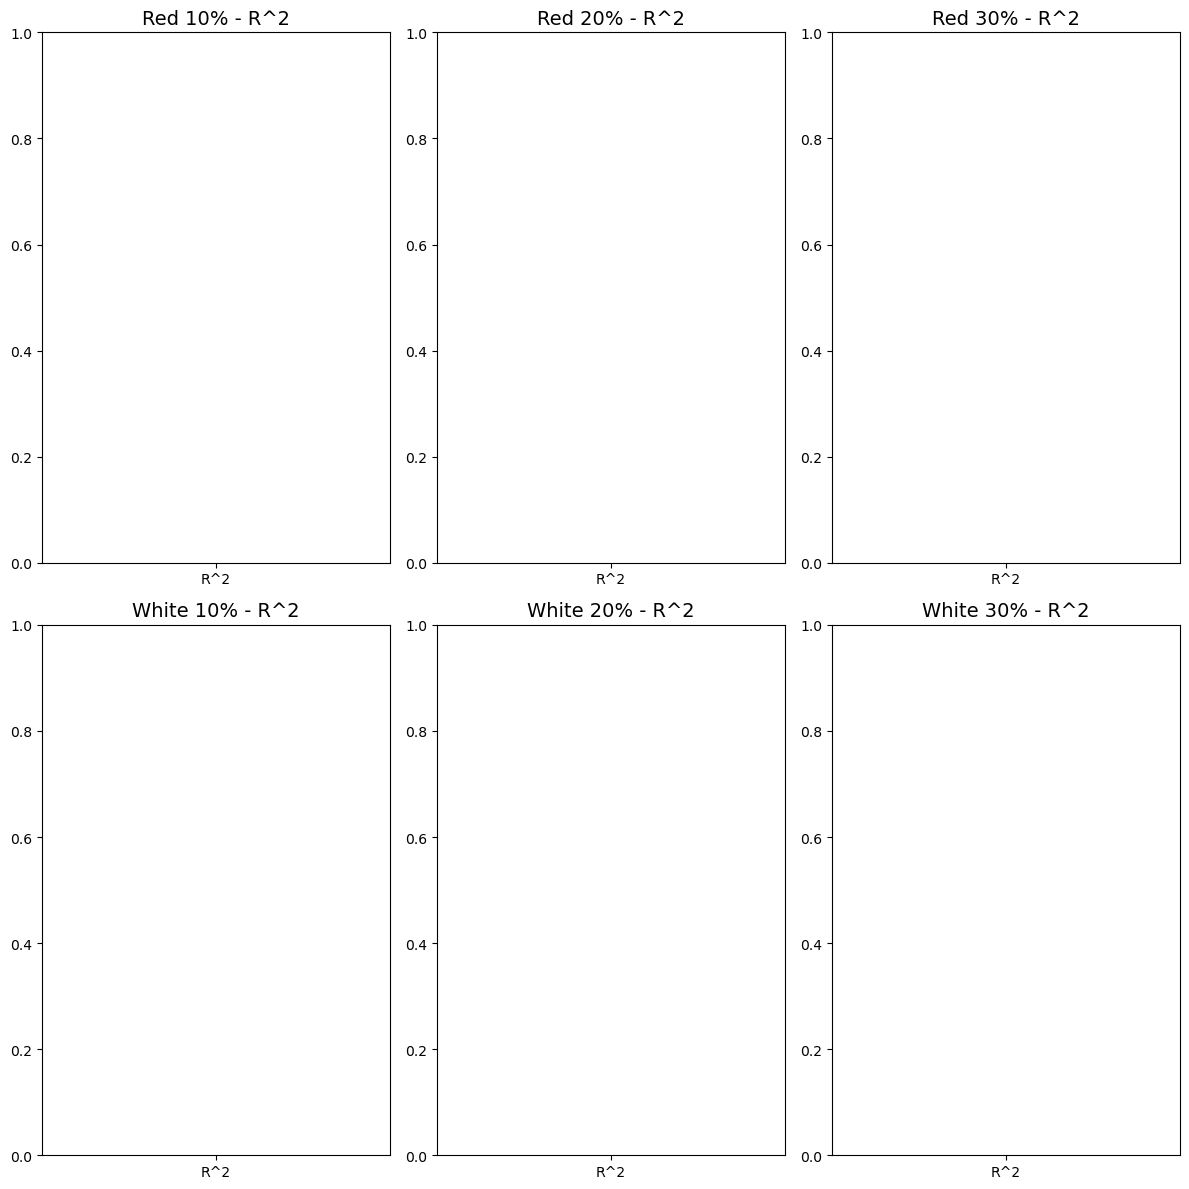

In [110]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor


datasets_names = ['Red 10%', 'Red 20%', 'Red 30%', 'White 10%', 'White 20%', 'White 30%']

def train_and_evaluate_model_cv(dataset_index, dataset, ax, use_r2=False):
    X = dataset.drop('quality', axis=1)
    y = dataset['quality']

    model = DecisionTreeRegressor()

    if use_r2:
        scores = cross_val_score(model, X, y, cv=5, scoring='r2')
        score_name = 'R^2'
    else:
        scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
        score_name = 'Accuracy'

    score = scores.mean()

    ax.bar([score_name], [score])
    ax.set_ylim([0, 1])
    ax.set_title(f"{datasets_names[dataset_index]} - {score_name}", fontsize=14)

fig, axs = plt.subplots(len(sampled_datasets_removal), len(sampled_datasets_removal[0]), figsize=(12, 12))

for i, datasets in enumerate(sampled_datasets_removal):
    for j, dataset in enumerate(datasets):
        dataset_index = i * len(sampled_datasets_removal[0]) + j
        ax = axs[i, j]
        train_and_evaluate_model_cv(dataset_index, dataset, ax)

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(len(sampled_datasets_restored), len(sampled_datasets_restored[0]), figsize=(12, 12))

for i, datasets in enumerate(sampled_datasets_restored):
    for j, dataset in enumerate(datasets):
        dataset_index = i * len(sampled_datasets_restored[0]) + j
        ax = axs[i, j]
        train_and_evaluate_model_cv(dataset_index, dataset, ax, use_r2=True)

plt.tight_layout()
plt.show()